In [1]:
# !pip install gym gym[atari] pyvirtualdisplay > /dev/null 2>&1
# !apt update > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# from google.colab import drive
# drive.mount('/content/drive')
# !ls drive
# !mkdir 'drive/My Drive/gym_model'
# !ln -s 'drive/My Drive/gym_model' model

In [2]:
import gym
from gym.wrappers import Monitor
gym.logger.set_level(gym.logger.INFO) 

import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from unittest.mock import MagicMock


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 200))
display.start();

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = sorted(glob.glob('video/*.mp4'))
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    gym.logger.debug('show video: path=%s', mp4)

    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                 controls >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, directory='./video', fake_reset=False):
  wenv = Monitor(env, directory, force=True)
  if fake_reset:
        wenv._before_reset()
        wenv._after_reset(None)
  return wenv

def safe_close(wenv):
    mock = MagicMock()
    mock.spec = wenv.env.spec
    wenv.env = mock
    wenv.close()

In [5]:
# env = gym.make('Seaquest-v0')
# wenv = wrap_env(env)
# observation = wenv.reset()

# for _ in range(10):
#     observation, reward, done, info = wenv.step(env.action_space.sample())
#     wenv.render()

# safe_close(wenv)
# show_video()

In [6]:
# wenv = wrap_env(env, fake_reset=True)
# for _ in range(10):
#     observation, reward, done, info = wenv.step(env.action_space.sample())
#     wenv.render()

# safe_close(wenv)
# show_video()

In [7]:
env = gym.make('Seaquest-v0')
observation = env.reset()
print(observation.shape)

INFO: Making new env: Seaquest-v0
(210, 160, 3)


In [8]:
def crop_image(img, start=20, height=160):
    return img[start:start+160]

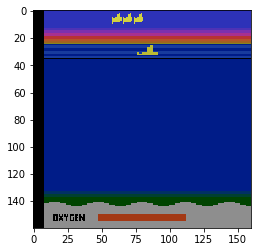

In [9]:
plt.imshow(crop_image(observation))

In [10]:
gray = tf.image.rgb_to_grayscale(observation)

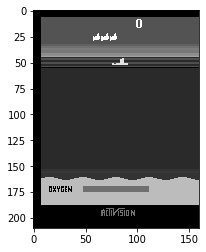

In [11]:
plt.imshow(gray[:,:,0], cmap='gray')

In [12]:
gray = tf.image.convert_image_dtype(gray, tf.float32)

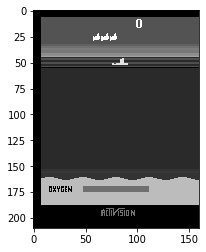

In [13]:
plt.imshow(gray[:,:,0], cmap='gray')

In [14]:
action_size = env.action_space.n
print(action_size)

18


In [15]:
def add_lstm_layer(input, units, initial_states, final_states, **kwargs):
    initial_memory_state = tf.keras.Input(shape=[units])
    initial_carry_state = tf.keras.Input(shape=[units])
    initial_state = [initial_memory_state, initial_carry_state]
    lstm = tf.keras.layers.LSTM(units, stateful=False, return_state=True, return_sequences=True,**kwargs)
    output, final_memory_state, final_carry_state = lstm(input, initial_state=initial_state)
    final_state =  [final_memory_state, final_carry_state]
    initial_states.append(initial_state)
    final_states.append(final_state)
    return output

def get_base_model(inputs, **kwargs):
    initail_states = []
    final_states = []
    x = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu', **kwargs)(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu', **kwargs)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(8, 3,  padding='same', activation='relu', **kwargs)(x)
    x = tf.keras.layers.MaxPool2D()(x)    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 0),name='to_sequence')(x)
    x = add_lstm_layer(x, 64, initail_states, final_states, **kwargs)
    x = add_lstm_layer(x, 64, initail_states, final_states, **kwargs)
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0),name='to_batch')(x)
    feature = tf.keras.layers.Dense(32, activation='relu', name="base_feature", **kwargs)(x)
    return tf.keras.Model(inputs =[inputs, initail_states], outputs=[feature, final_states])
        
    

In [16]:
class EntropyRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, scale=0.1, from_logits=True):
        self.scale=scale
        self.from_logits=from_logits
    def __call__(self, x):
        entropy = tf.keras.losses.categorical_crossentropy(x, x, from_logits=self.from_logits)
        return self.scale * tf.math.reduce_sum(entropy)
        

In [17]:
def get_action_model(action_size, **regularizers):
    screen = tf.keras.Input(shape=(160,160,1), name="screen")
    base_model = get_base_model(screen, **regularizers)
    logits = tf.keras.layers.Dense(action_size, name="logits", 
                                   activity_regularizer=EntropyRegularizer(),
                                   **regularizers)(base_model.output[0])
    action = tf.keras.layers.Lambda(lambda x: tf.random.categorical(x, 1), name='action')(logits)
    return tf.keras.Model(inputs = base_model.input, outputs=[action, base_model.output[1]], name="action")


In [18]:
def get_a3c_model(action_size, **regularizers):
    action_model = get_action_model(action_size, **regularizers)
    return get_a3c_model_from_action(action_model, **regularizers)
    
def get_a3c_model_from_action(action_model, **regularizers):
    feature = action_model.get_layer(name="base_feature").output
    score = tf.keras.layers.Dense(1, name="state_score",**regularizers)(feature)
    outputs = [action_model.output[0], score, action_model.output[1]]
    return tf.keras.Model(inputs = action_model.input, outputs=outputs)

In [19]:
class SparseCategorialCrossEntropy(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.losses.sparse_categorical_crossentropy(inputs[0], inputs[1], from_logits=True)  

In [20]:
def get_train_model_from(a3c_model):
    target_score = tf.keras.Input(shape=(1,), name="target_score")
    sample_action = tf.keras.Input(shape=(1,), dtype=tf.int32, name="sample_action")
    state_score = a3c_model.get_layer(name="state_score").output
    logits = a3c_model.get_layer(name="logits").output
    cross_entropy=SparseCategorialCrossEntropy(name="logits_cross_entrofy")([sample_action, logits])
    action_gain = tf.keras.layers.Subtract(name="action_gain", 
                                           activity_regularizer=lambda x: tf.math.reduce_sum(tf.math.square(x)))
    action_gain = action_gain([target_score, state_score])
    action_loss = tf.keras.layers.Multiply(name="action_loss",
                                           activity_regularizer=tf.math.reduce_sum)
    action_loss = action_loss([cross_entropy, action_gain])
    return tf.keras.Model(inputs= [a3c_model.input, sample_action, target_score],
                          outputs = action_loss)

In [23]:
a3c_model = get_a3c_model(action_size, kernel_regularizer="l1_l2", bias_regularizer="l1_l2")
train_model =  get_train_model_from(a3c_model)

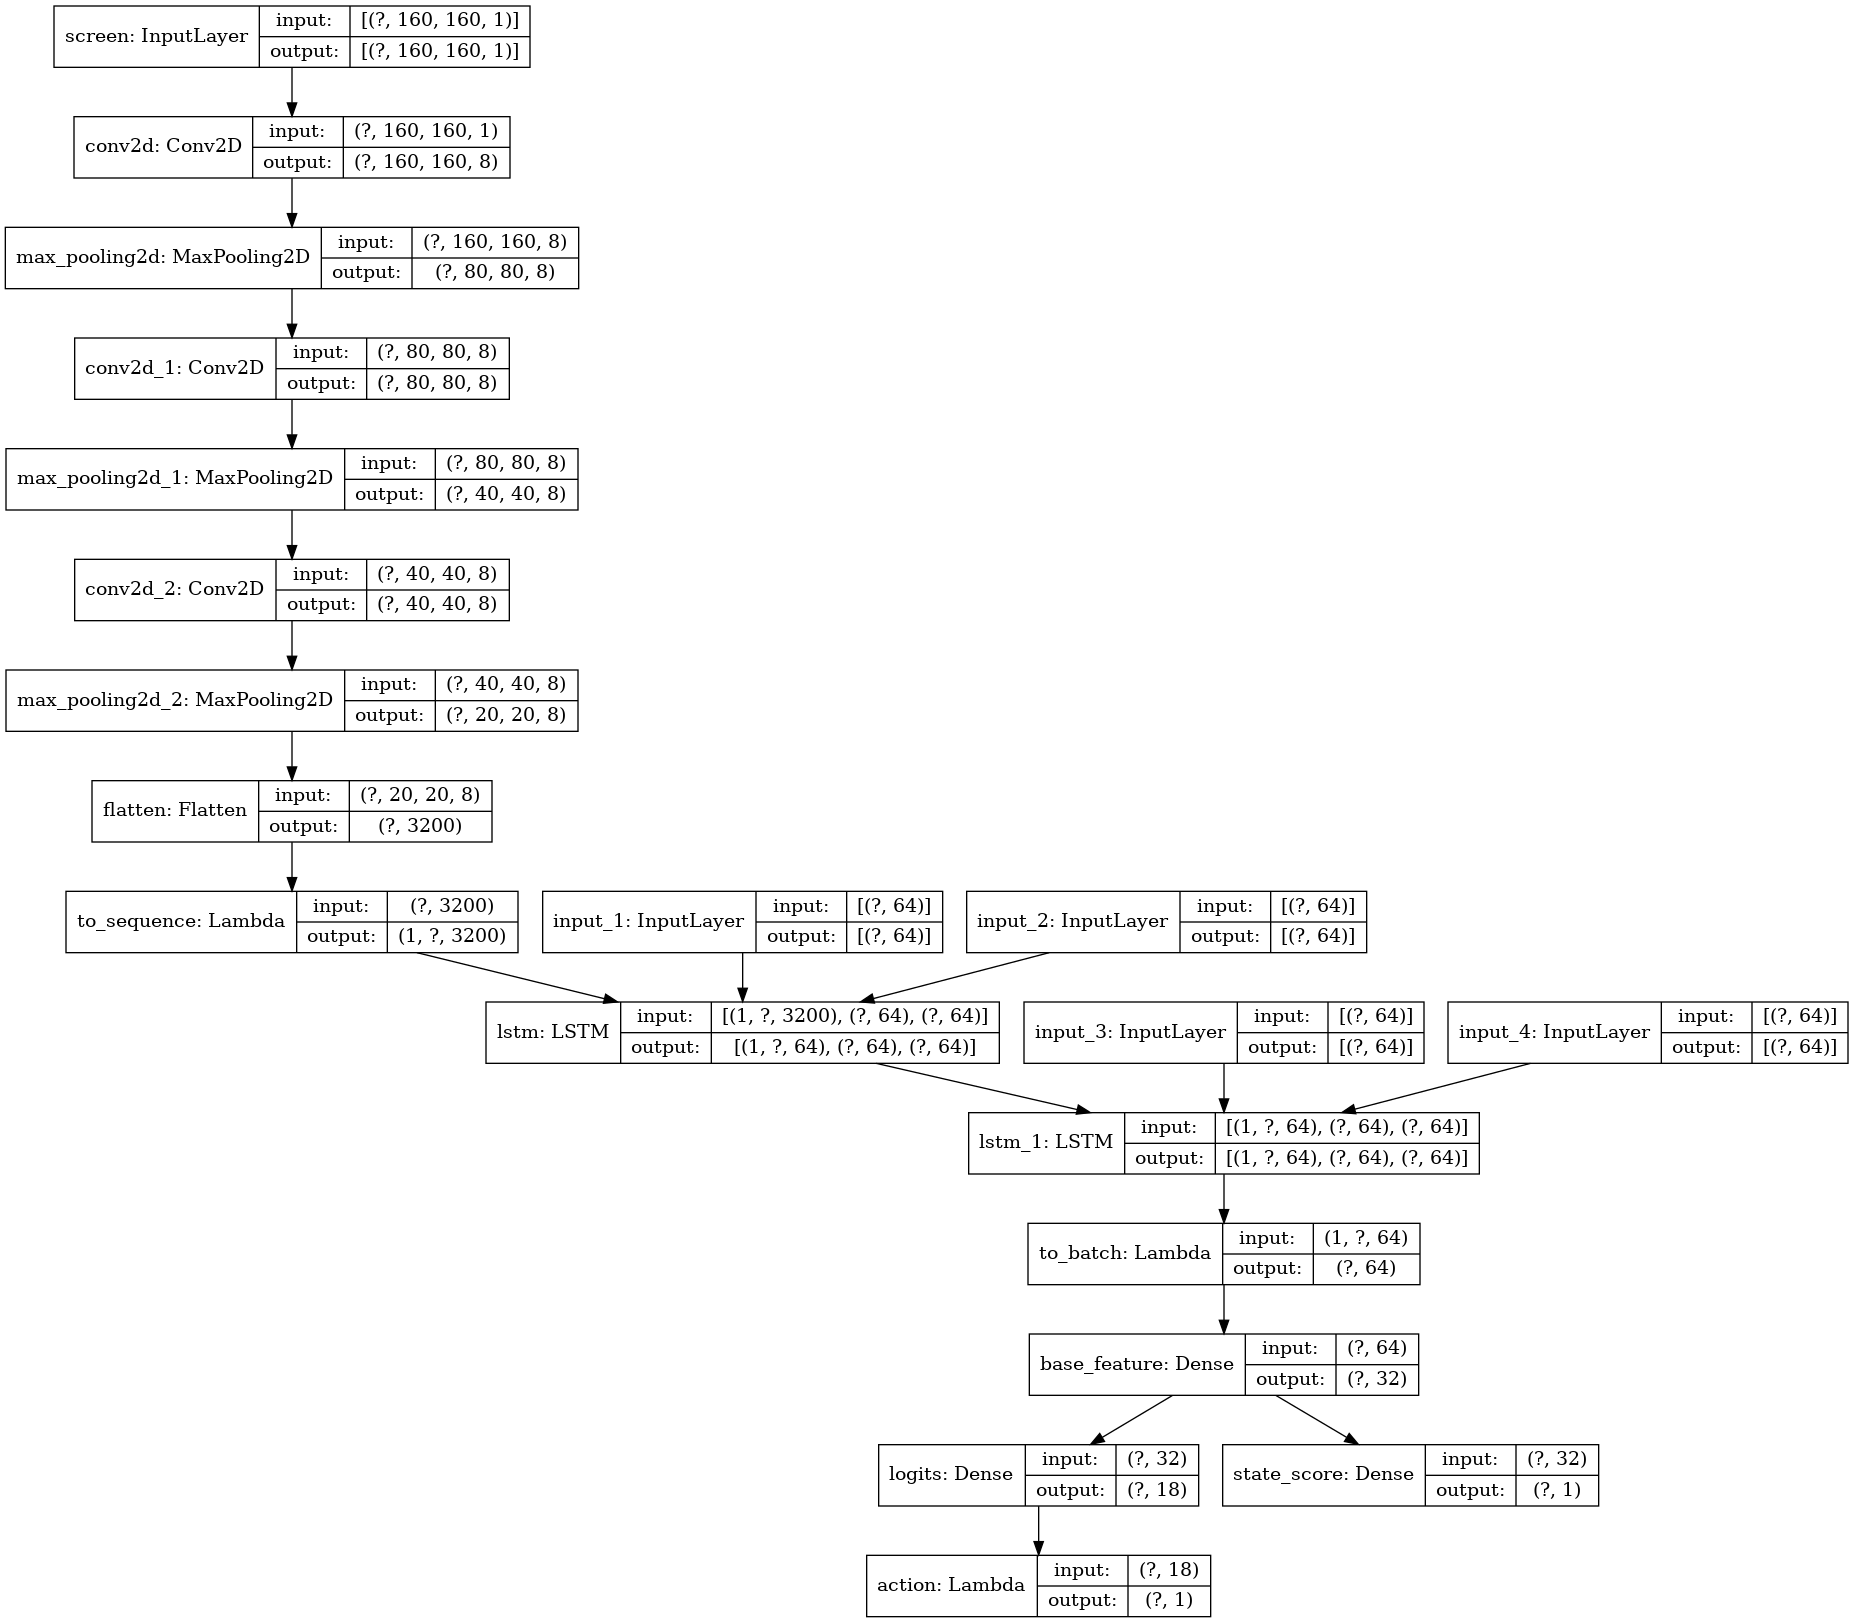

In [24]:
tf.keras.utils.plot_model(a3c_model, show_shapes=True)

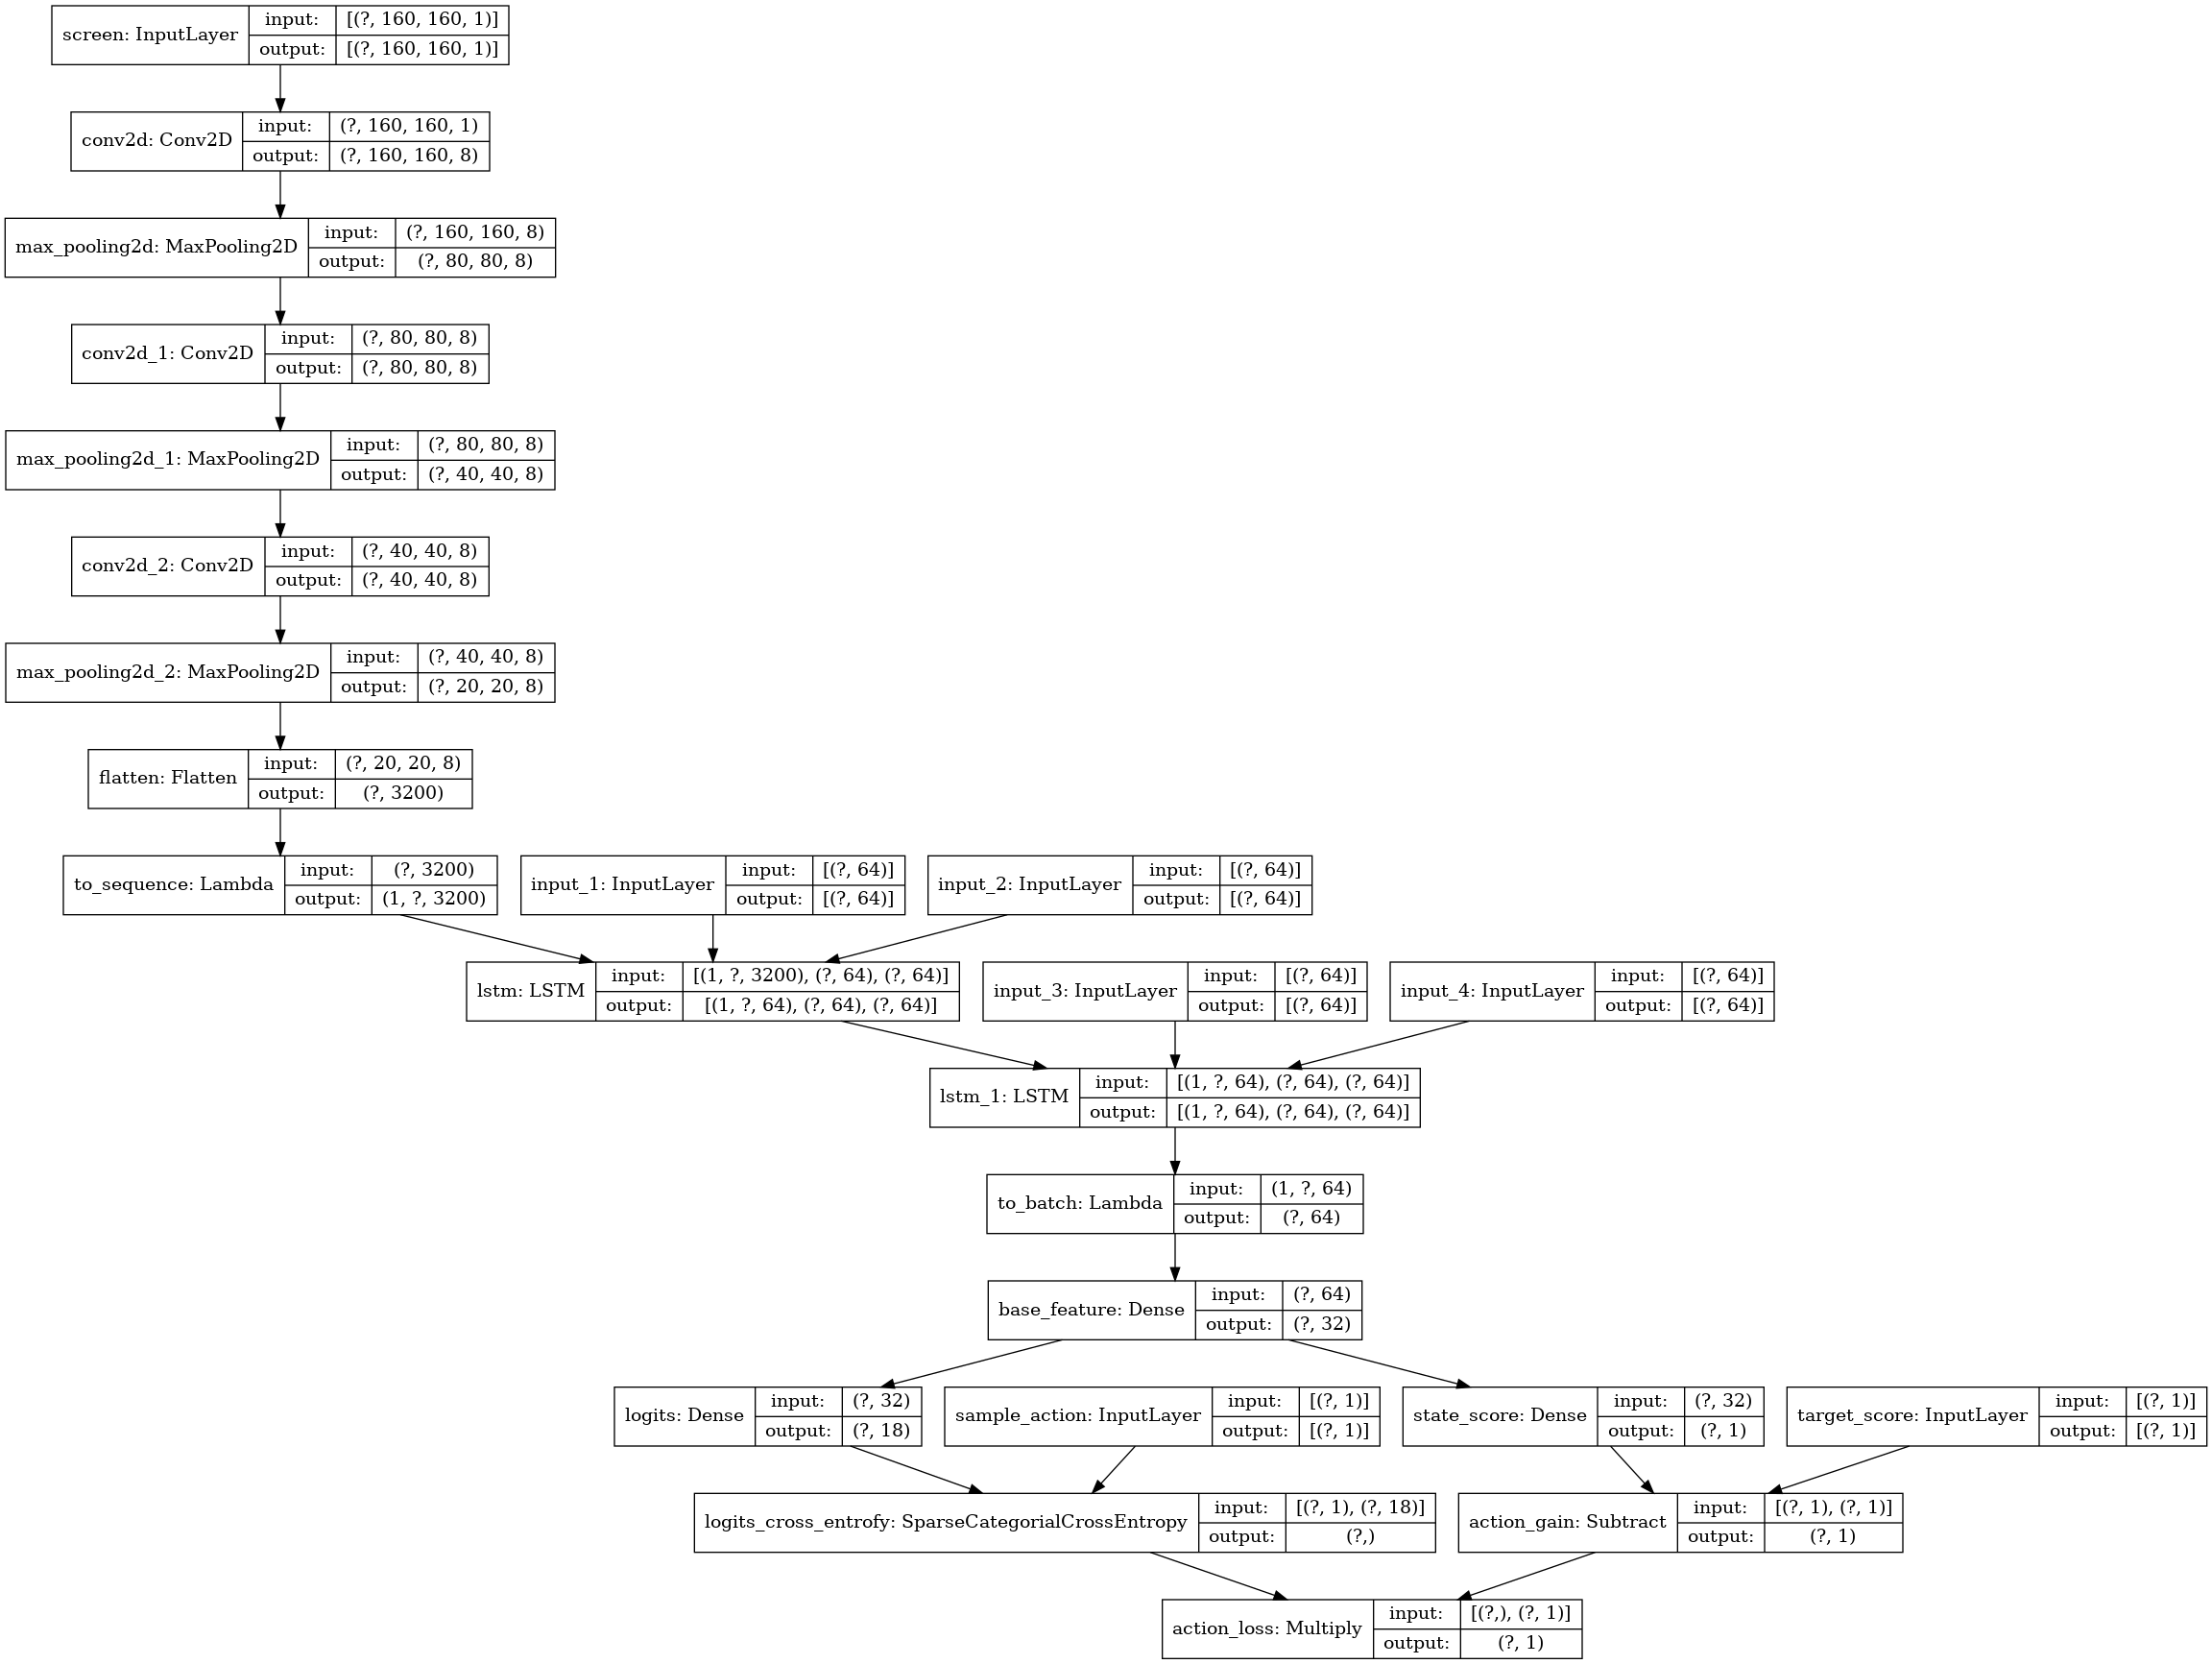

In [25]:
tf.keras.utils.plot_model(train_model, show_shapes=True)

In [26]:
train_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
screen (InputLayer)             [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 8)  80          screen[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 8)    584         max_pooling2d[0][0]              
____________________________________________________________________________________________

In [27]:
# "input:", a3c_model.input,"output:", a3c_model.output

In [28]:
# "input:", train_model.input,"output:", train_model.output

In [29]:
# train_model.losses, len(train_model.losses)

In [30]:
def get_zero_state(state, batch_size = 1):
    if type(state) == list:
        return [get_zero_state(x) for x in state]
    if type(state) == tf.Tensor:
        shape = state.shape.as_list()
        shape[0] = batch_size
        return tf.zeros(shape, dtype=state.dtype)
    raise ValueError("state is not a valid type")

In [31]:
def observation_to_screen(observation, start_row):
    img =  crop_image(observation, start=start_row)
    img =  tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [32]:
   
def play(model, env, initial_state = None, max_step=6000, render=False, record=False, start_row=20):
    screens = []
    actions = []
    rewards = []

    if initial_state != None:
        gym.logger.debug("resumming play")
        score, done, observation, model_state = initial_state
    else:
        gym.logger.debug("new play")
        score = 0
        done = False
        observation = env.reset()
        model_state = get_zero_state(model.input[1])
    if score < 0:
        gym.logger.error("got score: {} is negative.".format(score))

    for t in range(max_step):
        if render:
            env.render()            
        screen = observation_to_screen(observation, start_row)        
        action, _, model_state = model([tf.stack([screen]), model_state])
        action = action[0][0].numpy()
        gym.logger.debug("will step with action: %d", action)
        observation, reward, done, info = env.step(action)     
        if reward < 0:
            gym.logger.error("step reward: {} is negative. current_score:{}".format(reward, score))
        score += reward       
        if record:
            screens.append(screen)
            actions.append([action])
            rewards.append([reward])
        if done:
            break
    gym.logger.debug("finished with score: {} after {} timesteps".format(score, t+1))
    if len(screens) > 0:
        screens = tf.stack(screens)
        actions = tf.stack(actions)
        rewards = tf.stack(rewards)
        
    return [score, done, observation, model_state], [screens, actions, rewards]

In [33]:
def evaluate(model, env, initial_state = None, render=True, **kwargs):
    if render:
        fake_reset = initial_state != None
        gym.logger.debug("fake reset: {}".format(fake_reset))
        env = wrap_env(env, fake_reset= fake_reset)
    state, _ = play(model, env, render=render, record=False, initial_state=initial_state, **kwargs)
    gym.logger.info("Evaluation finished with score:{}".format(state[0]))
    if render:
        safe_close(env)
        show_video()
    return state

def record_play(model, env, **kwargs)    :
    return play(model, env, render=False, record=True, **kwargs)

In [34]:
def estimate_score(rewards, last=0, future_discount=0.99):
    scores = []
    for r in reversed(rewards):
        last = last + r
        scores.insert(0,last)
        last *= future_discount
    scores = tf.stack(scores)
    return scores


In [35]:
def train_one_episode(env, a3c_model, train_model, optimizer, batch_size=64, start_row=20):
    
    record_state = None
    initial_train_state = get_zero_state(a3c_model.input[1])
    done = False
    batch = 0
    while not done:
        record_state, [screens, actions, rewards] = record_play(a3c_model, env,                                                          
                                                                initial_state = record_state,
                                                                start_row=start_row,
                                                                max_step=batch_size)
        score, done, observation, model_state = record_state
        if not done:
            screen = observation_to_screen(observation, start_row)
            _, state_score, _= a3c_model([tf.stack([screen]), model_state])
            last = state_score[0][0]
        else:
            last = 0
        target_score = estimate_score(rewards, last)
        train_model_input = [[screens, initial_train_state], actions, target_score]
        with tf.GradientTape() as tape:
            out = train_model(train_model_input)
            loss_value = tf.reduce_sum(train_model.losses)
        grads = tape.gradient(loss_value, train_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, train_model.trainable_weights))    
        initial_train_state = model_state
        batch += 1
        if batch % 10 == 0:
            gym.logger.info("training score:{} at batch:{}".format(score, batch))
    gym.logger.info("training episode finished with score:{} at batch:{}".format(score, batch))
    return 
            
    

In [36]:
gym.logger.set_level(gym.logger.INFO) 

In [37]:
time state = evaluate(a3c_model, env, max_step=600)

INFO: Clearing 7 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /workshop/atari_games/video/openaigym.video.0.1248.video000000.mp4
INFO: Evaluation finished with score:20.0
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/workshop/atari_games/video')


CPU times: user 7.79 s, sys: 657 ms, total: 8.45 s
Wall time: 7.97 s


In [38]:
time out = record_play(a3c_model, env)

CPU times: user 5.71 s, sys: 165 ms, total: 5.87 s
Wall time: 5.41 s


In [39]:
optimizer = tf.keras.optimizers.RMSprop()

In [40]:
time train_one_episode(env, a3c_model, train_model, optimizer, batch_size=32)

INFO: training score:20.0 at batch:10
INFO: training score:40.0 at batch:20
INFO: training episode finished with score:60.0 at batch:26
CPU times: user 12.3 s, sys: 343 ms, total: 12.6 s
Wall time: 11.4 s


In [64]:
for episode in range(10):
    start_time = time.time()
    score = train_one_episode(env, a3c_model, train_model, optimizer, batch_size=32)
    gym.logger.info("time used for episode %d: %d sec", episode, time.time() - start_time)

INFO: training score:80.0 at batch:10
INFO: training score:120.0 at batch:20
INFO: training score:160.0 at batch:30
INFO: training episode finished with score:220.0 at batch:38
INFO: time used for episode 0: 16 sec
INFO: training score:20.0 at batch:10
INFO: training score:60.0 at batch:20
INFO: training episode finished with score:100.0 at batch:28
INFO: time used for episode 1: 12 sec
INFO: training score:80.0 at batch:10
INFO: training score:140.0 at batch:20
INFO: training score:200.0 at batch:30
INFO: training score:240.0 at batch:40
INFO: training episode finished with score:260.0 at batch:43
INFO: time used for episode 2: 18 sec
INFO: training score:20.0 at batch:10
INFO: training score:80.0 at batch:20
INFO: training score:100.0 at batch:30
INFO: training episode finished with score:120.0 at batch:34
INFO: time used for episode 3: 14 sec
INFO: training score:20.0 at batch:10
INFO: training score:100.0 at batch:20
INFO: training episode finished with score:120.0 at batch:28
INFO

KeyboardInterrupt: 

In [ ]:
#state = evaluate(a3c_model, env, max_step=6000)

In [ ]:
# from datetime import datetime

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()



In [ ]:
# logdir='./logs/gym'
# board_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
# board_cb.set_model(train_model)

In [ ]:
# epochs = 10
# batchs_per_epochs = 10
# cbs = [board_cb]

# for epoch in range(epochs):
#     for cb in cbs:
#         cb.on_epoch_begin(epoch)
#     for batch in range(batchs_per_epochs):
#         for cb in cbs:
#             cb.on_train_batch_begin(batch)
            
#         for cb in cbs:
#             cb.on_train_batch_end(batch)
#     for cb in cbs:
#         logs={
#             "score": epoch
#         }
#         cb.on_epoch_end(epoch)
# for cb in cbs:
#     cb.on_train_end()



In [ ]:
# %load_ext tensorboard
# %tensorboard --host=0.0.0.0 --logdir logs 